In [31]:
filename = "random"
id = 0
path = "./parquet_files/"

In [32]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from matplotlib import colormaps
import seaborn as sns
import glob
import re

ensemble = True
hms = True
vid = False
pdfs = False

x_max = 400
y_max = 400
z_max = 1

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use("seaborn-v0_8-whitegrid")

organism_group_labels = [
    "Bacteria",
    "Fungi",
    "Root-feeding Nematodes",
    "Bacterivorous Nematodes",
    "Fungivorous Nematodes",
    "Omnivorous Nematodes",
    "Fungivorous Mites",
    "Omnivorous Mites",
    "Collembolans",
]


def rand_jitter(arr):
    if len(arr):
        stdev = 0.001 * (max(arr) - min(arr))
        return arr + np.random.randn(len(arr)) * stdev
    return arr


df = pl.read_parquet(path + filename + "_" + str(id) + ".parquet")

n = len(df["type"].unique())
colors = colormaps["tab10"].colors

counts_per_type = (
    df.group_by(["type", "tick"])
    .agg(pl.len().alias("agent_count"))
    .sort(["type", "tick"])
)

In [33]:
df_first = df.filter(pl.col("tick") == 0)
df_last = df.filter(pl.col("tick") == pl.col("tick").max() - 1)
print("\t\t tick = 0", "\t tick =", df["tick"].max())
print("Total:\t\t", len(df_first), "\t\t", len(df_last), "\n")
type_labels = {
    0: "Bacteria",
    1: "Fungi",
    2: "R.F. Nems",
    3: "B. Nems",
    4: "F. Nems",
    5: "O. Nems",
    6: "F. Mites",
    7: "O. Mites",
    8: "Collembolans",
}

# Group and count
first_counts = df_first.group_by("type").len().sort("type")
last_counts = df_last.group_by("type").len().sort("type")

# Convert to dict for easier lookup
first_dict = dict(zip(first_counts["type"], first_counts["len"]))
last_dict = dict(zip(last_counts["type"], last_counts["len"]))

# Print summary table
for t in range(9):
    label = type_labels[t]
    c1 = first_dict.get(t, 0)
    c2 = last_dict.get(t, 0)
    print(f"{label:<13}\t{c1:<8}\t{c2}")

		 tick = 0 	 tick = 100
Total:		 87137 		 35760 

Bacteria     	43565   	20814
Fungi        	15529   	10924
R.F. Nems    	6322    	2414
B. Nems      	8995    	1066
F. Nems      	6214    	12
O. Nems      	4086    	512
F. Mites     	931     	7
O. Mites     	416     	0
Collembolans 	1079    	11


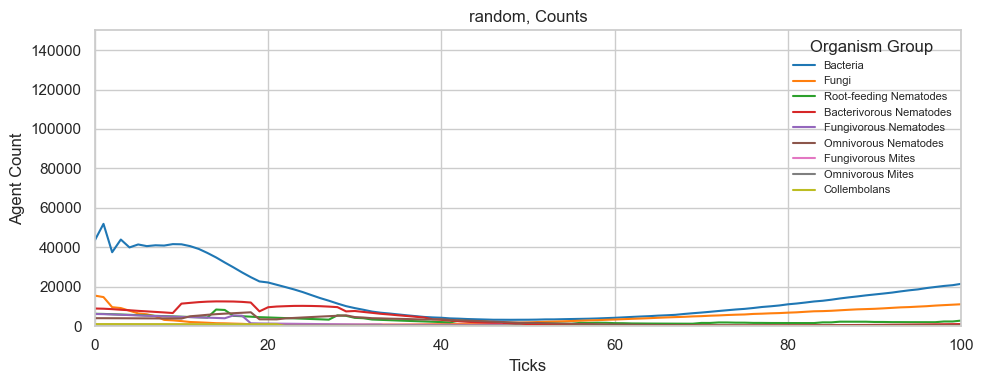

In [34]:
# Plot using seaborn
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 4))

# Plot one line per group manually to apply color
for _, group_df in counts_per_type.group_by("type"):
    t = group_df["type"][0]
    sns.lineplot(
        data=group_df,
        x="tick",
        y="agent_count",
        label=organism_group_labels[t],
        color=colors[t],
        ax=ax,
    )

# Styling
ax.set_xlim(0, counts_per_type["tick"].max())
ax.set_ylim(0, 150000)
ax.set_xlabel("Ticks")
ax.set_ylabel("Agent Count")
ax.set_title(f"{filename}, Counts")
ax.legend(title="Organism Group", fontsize=8)

plt.tight_layout()

# Save if enabled
if pdfs:
    plt.savefig(f"./agent_counts_viz/{filename}.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [35]:
if df.get_column("biomass", default=0):
    df_som = pl.read_parquet(path + filename + "_" + str(id) + "_SOM.parquet")
    
    # Group biomass by tick
    biomass_per_tick = (
        df.group_by("tick").agg(pl.col("biomass").sum().alias("total_biomass")).sort("tick")
    )
    
    # Group SOM values by tick (mean, sum, etc. depending on what makes sense)
    som_per_tick = (
        df_som.group_by("tick")
        .agg(pl.col("som_value").sum().alias("total_som"))
        .sort("tick")
    )
    
    # Merge both on 'tick'
    combined = biomass_per_tick.join(som_per_tick, on="tick")
    
    
    # Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 4))
    sns.lineplot(
        data=combined,
        x="tick",
        y="total_som",
        label="Total SOM",
        color="teal",
    )
    sns.lineplot(
        data=combined,
        x="tick",
        y="total_biomass",
        label="Total Biomass",
        color="purple",
    )
    
    # Labels and legend
    plt.xlabel("Tick")
    plt.ylabel("Value")
    plt.title("Total Biomass and SOM Over Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [36]:
if df.get_column("age", default=0):
    # Group by tick and type, then compute mean age
    mean_age = (
        df.group_by(["tick", "type"])
        .agg(pl.col("age").mean().alias("mean_age"))
        .sort(["tick", "type"])
    )

    # Plot with hue = type
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=mean_age, x="tick", y="mean_age", hue="type", palette="tab10")

    # Labels and legend
    plt.xlabel("Tick")
    plt.ylabel("Mean Age")
    plt.title("Mean Age per Type Over Time")
    plt.legend(title="Type")
    plt.tight_layout()
    plt.savefig("age.pdf")
    plt.show()

In [37]:
if df.get_column("biomass", default=0):
    # Group by tick and type, then compute mean age
    mean_biomass = (
        df.group_by(["tick", "type"])
        .agg(pl.col("biomass").mean().alias("mean_biomass"))
        .sort(["tick", "type"])
    )
    
    # Plot with hue = type
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=mean_biomass, x="tick", y="mean_biomass", hue="type", palette="tab10")
    
    # Labels and legend
    plt.xlabel("Tick")
    plt.ylabel("Mean Biomass")
    plt.title("Mean Biomass per Type Over Time")
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()

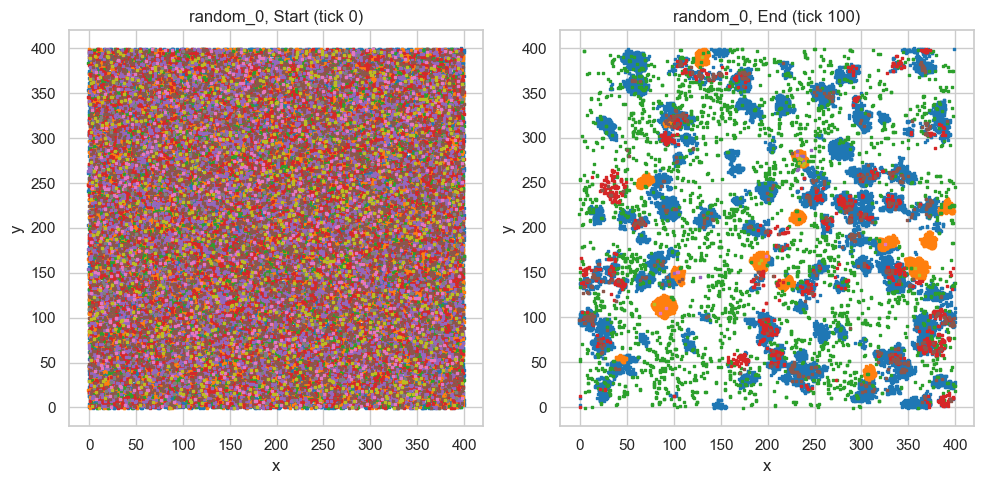

In [38]:
# Get max tick value first
tick_min = df["tick"].min()
tick_max = df["tick"].max()

if hms:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, (tick_value, label) in enumerate([(tick_min, "Start"), (tick_max, "End")]):
        ax = axes[i]

        df_tick = df.filter(pl.col("tick") == tick_value).to_pandas()

        for t in np.unique(df_tick["type"]):
            subset = df_tick[df_tick["type"] == t]
            ax.scatter(
                rand_jitter(subset["x"].values),
                rand_jitter(subset["y"].values),
                color=colors[t],
                label=f"Type {t}",
                s=1,
                marker="s",
            )

        ax.set_title(f"{filename}_{id}, {label} (tick {tick_value})")
        ax.set_xlabel("x")
        ax.set_ylabel("y")

    plt.tight_layout()

    if pdfs:
        plt.savefig(
            f"./heatmaps/{filename}_hm_start_end.pdf", format="pdf", bbox_inches="tight"
        )

    plt.show()

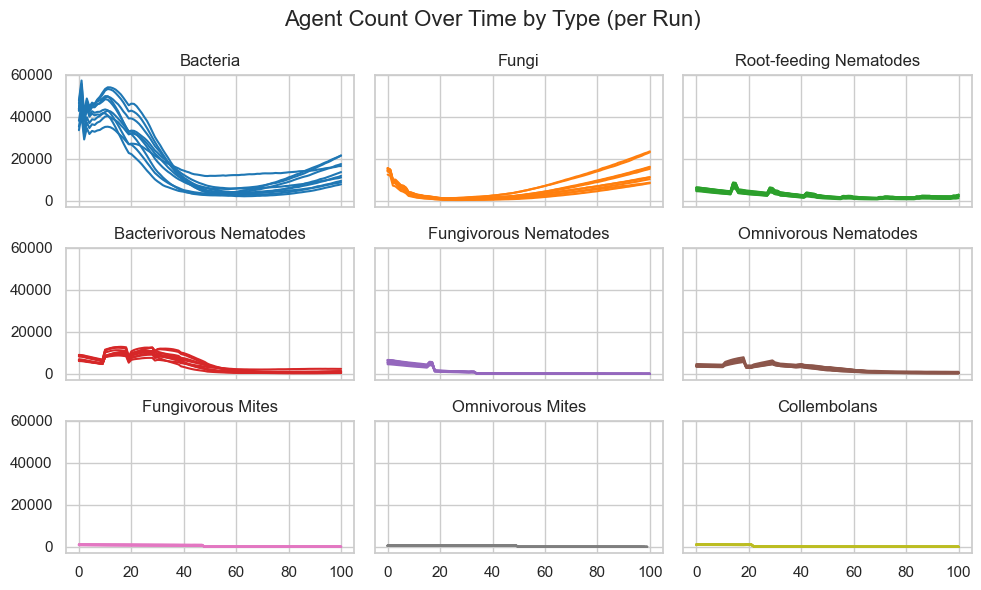

In [39]:
# Get all merged parquet files
files = glob.glob(path + filename + "_*.parquet")
# Store one DataFrame per run
runs = {}
for f in files:
    # Extract setup ID from filename (e.g., setup_3_merged.parquet → 3)
    match = re.search(filename + r"_(\d+).parquet", f)
    if match:
        setup_id = int(match.group(1))
        df = pl.read_parquet(f)
        runs[setup_id] = df
# Prepare plot
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharex=True, sharey=True)
axes = axes.flatten()
# Define colors for different runs
colors = plt.cm.tab10.colors
# Plot each type (0–8)
for t in range(9):
    ax = axes[t]
    for idx, (setup_id, df) in enumerate(runs.items()):
        # Filter by type
        df_type = df.filter(pl.col("type") == t)
        # Group by tick, count agents
        grouped = (
            df_type.group_by("tick").agg(pl.count("type").alias("count")).sort("tick")
        )
        ticks = grouped["tick"].to_numpy()
        counts = grouped["count"].to_numpy()
        ax.plot(ticks, counts, label=f"Run {setup_id}", color=colors[t])
    ax.set_title(f"{organism_group_labels[t]}")
    ax.grid(True)
# Tidy up
fig.suptitle("Agent Count Over Time by Type (per Run)", fontsize=16)
plt.tight_layout()
plt.show()
